<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Create-a-data-generator" data-toc-modified-id="Create-a-data-generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a data generator</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import evaluation
import pandas as pd
import _pickle as cPickle

# Load data

In [2]:
data_dir = "./data/"  + "dataset/"

MFCC_LEN_LIM = 700
N_MFCC = 13

In [3]:
import _pickle as cPickle

with open(data_dir + "data_mfcc_for_generator.pkl", 'rb') as f:
    data_mfcc = cPickle.load(f)

In [4]:
audio_pairs_df = pd.read_csv("./data/audio_sentence_pairs_full.csv")
audio_pairs_df

,student_I_id,article_I_id,sentence_I_id,student_II_id,article_II_id,sentence_II_id
0,18021206_HoVanThep,9,15,18021206_HoVanThep,6,11
1,18021174_TranTrungThanh,4,13,17021242_PhamTuanHiep,4,13
2,18020370_NguyenManhDung,1,12,18020370_NguyenManhDung,1,33
3,18021027_LeThiPhuong,0,13,18021027_LeThiPhuong,2,6
4,17021340_ThieuMinhThinh,2,20,18020557_NguyenHuyHoang,2,20
...,...,...,...,...,...,...
999995,18020131_TranDucAnh,2,39,17021313_DinhCongPhan,2,39
999996,18020131_TranDucAnh,5,5,18020131_TranDucAnh,0,7
999997,18020370_NguyenManhDung,6,4,18020370_NguyenManhDung,7,29
999998,18020131_TranDucAnh,1,0,18020131_TranDucAnh,2,28


In [5]:
audio_pairs = audio_pairs_df.to_numpy()

In [6]:
def load_data(folds):
    X = []
    y = []
    for fold in folds:
        with open(data_dir + f"data_mfcc_{fold}.pkl", 'rb') as f:
            data_mfcc = cPickle.load(f)

        for i in range(len(data_mfcc['sentence_I'])):
            if data_mfcc['sentence_I'][i].shape[0] < MFCC_LEN_LIM:
                sentence_I = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_I[-data_mfcc['sentence_I'][i].shape[0]:] = data_mfcc['sentence_I'][i]
            else:
                sentence_I = data_mfcc['sentence_I'][i]
                
            if data_mfcc['sentence_II'][i].shape[0] < MFCC_LEN_LIM:
                sentence_II = np.zeros((MFCC_LEN_LIM, N_MFCC), dtype=np.float32)
                sentence_II[-data_mfcc['sentence_II'][i].shape[0]:] = data_mfcc['sentence_II'][i]
            else:
                sentence_II = data_mfcc['sentence_II'][i]
            X.append([sentence_I, sentence_II])
            y.append(data_mfcc['same_speaker'][i])
    return np.array(X), np.array(y)

In [7]:
X_val, y_val = load_data(["val"])
X_val.shape

(10000, 2, 700, 13)

# Create a data generator

In [8]:
import numpy as np
import tensorflow as tf
import random

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return int(np.floor(len(audio_pairs) / self.batch_size))
    
    def __getitem__(self, index):
        pairs = audio_pairs[index*self.batch_size:(index+1)*self.batch_size]
        X_1 = []
        X_2 = []
        y = []
        for pair in pairs:
            student_I_id, article_I_id, sentence_I_id = pair[0], pair[1], pair[2]
            student_II_id, article_II_id, sentence_II_id = pair[3], pair[4], pair[5]
            X_1.append(data_mfcc[student_I_id][article_I_id][sentence_I_id])
            X_2.append(data_mfcc[student_II_id][article_II_id][sentence_II_id])
            y.append(student_I_id == student_II_id)
            
#         X_1 = np.array(X_1)
#         X_1 = np.expand_dims(X_1, axis=X_1.ndim)
        
#         X_2 = np.array(X_2)
#         X_2 = np.expand_dims(X_2, axis=X_2.ndim)
        return [np.array(X_1), np.array(X_2)], np.array(y)
    
    def on_epoch_end(self):
        random.shuffle(audio_pairs)

# Train model

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [11]:
class CNN_CNN:
    def __init__(self, num_features, learning_rate=0.001):
        self.num_features = num_features
        self.learning_rate = learning_rate
        
        self.classifier = self.build_classifier()
    
    def build_classifier(self):
        input_1 = Input(shape = (700, self.num_features,1))
        input_2 = Input(shape = (700, self.num_features,1))
        
        
        out1 = Conv2D(32, kernel_size=(3, 1), activation='relu')(input_1)
        out1 = AveragePooling2D(pool_size=(2, 1), strides=2)(out1)
        
        out1 = Conv2D(64, kernel_size=(3, 1), activation='relu')(out1)
        out1 = AveragePooling2D(pool_size=(2, 1), strides=2)(out1)
        
        out1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(out1)
        out1 = AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(out1)
        
        out1 = Flatten()(out1)
        dropout_1 = Dropout(0.3)(out1)
        output1 = Dense(32, activation = "relu", kernel_initializer='glorot_uniform')(dropout_1)
        
        
        
        
        out2 = Conv2D(32, kernel_size=(3, 1), activation='relu')(input_2)
        out2 = AveragePooling2D(pool_size=(2, 1), strides=2)(out2)
        
        out2 = Conv2D(64, kernel_size=(3, 1), activation='relu')(out2)
        out2 = AveragePooling2D(pool_size=(2, 1), strides=2)(out2)
        
        out2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(out2)
        out2 = AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(out2)
        
        out2 = Flatten()(out2)
        dropout_2 = Dropout(0.3)(out2)
        output2 = Dense(32, activation = "relu", kernel_initializer='glorot_uniform')(dropout_2)
        
        
        merge = concatenate([output1, output2], axis = 1)
        dense_1 = Dense(32, activation = "relu", kernel_initializer='glorot_uniform')(merge)
        dropout_1 = Dropout(0.3)(dense_1)
        
        dense_2 = Dense(16, activation = "relu", kernel_initializer='glorot_uniform')(dropout_1)
        dropout_2 = Dropout(0.3)(dense_2)
        
        dense_3 = Dense(1, activation ="sigmoid", kernel_initializer='glorot_uniform')(dropout_2)

        model = Model(inputs = [input_1, input_2], outputs = dense_3)
        model.compile(optimizer = Adam(self.learning_rate), loss = "binary_crossentropy", metrics = ["acc"])

        model.summary()
        return model
    
    def plot(self):
        return tf.keras.utils.plot_model(self.classifier, to_file='modeling/cnn_cnn.png', show_shapes=True, show_layer_names=True)
    
    def save_weights(self):
        self.classifier.save_weights('saved_model/cnn_cnn_weights.h5')
        
    def load_weights(self):
        self.classifier.load_weights('saved_model/cnn_cnn_weights.h5')
            
    def fit(self, generator, epochs=50, early_stopping_rounds=7, X_val=None, y_val=None):
        model_dir = './checkpoints/'
        callbacks = [
#             tf.keras.callbacks.EarlyStopping(patience=early_stopping_rounds,
#                                              monitor='val_acc',
#                                              restore_best_weights=True),
#             tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, "weights-epoch{epoch:02d}-loss{val_loss:.2f}-acc{val_acc:.2f}.h5"),
#                                               save_weights_only=True,
#                                               monitor='val_acc',
#                                               mode='max',
#                                               save_best_only=True)
            ]
        
        history = self.classifier.fit(generator,
                                      epochs=epochs,
                                      verbose=1,
                                      callbacks=callbacks,
                                      validation_data=([X_val[:,0], X_val[:,1]], y_val),
                                      use_multiprocessing=False,
                                      workers=6
                                     )
        return history
    
    def predict(self, X):
        return self.predict_proba(X) >= 0.5
    
    def predict_proba(self, X):
        y = self.classifier.predict([X[:,0], X[:,1]])
        return y

In [12]:
model = CNN_CNN(num_features=N_MFCC)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700, 13, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 700, 13, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 698, 13, 32)  128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 698, 13, 32)  128         input_2[0][0]                    
______________________________________________________________________________________________

In [13]:
train_generator = DataGenerator()
model.fit(train_generator, epochs=3, early_stopping_rounds=2, X_val=X_val, y_val=y_val)

Epoch 1/3
31250/31250 [==============================] - 1435s 46ms/step - loss: 0.5486 - acc: 0.7309 - val_loss: 0.5157 - val_acc: 0.7673
Epoch 2/3
31250/31250 [==============================] - 1399s 45ms/step - loss: 0.3394 - acc: 0.8597 - val_loss: 0.6724 - val_acc: 0.7575
Epoch 3/3
31250/31250 [==============================] - ETA: 0s - loss: 0.1723 - acc: 0.9395

IndexError: list index out of range

In [19]:
model.save_weights()

# Evaluation

In [ ]:
model.load_weights()

In [14]:
X_test, y_test = load_data(["test"])

In [15]:
y_pred = model.predict(X_test)

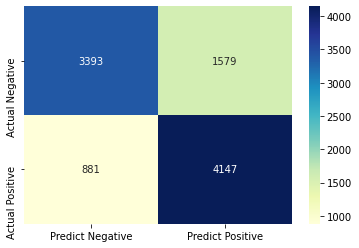

In [16]:
evaluation.plot_confusion_matrix(y_test, y_pred)

In [17]:
evaluation.print_classification_report(y_test, y_pred)

Classification report:
               precision    recall  f1-score   support

       False       0.79      0.68      0.73      4972
        True       0.72      0.82      0.77      5028

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



In [18]:
evaluation.get_f1_score(y_test, y_pred, average='macro')

0.7525934542020916